In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [42]:
# Read the matching results csv file
dfl = pd.read_csv('matching_detr_oap_r101_eos010_d.csv')
dfnl = pd.read_csv('matching_detr_oap_r101_eos010_nod.csv')
gt = pd.read_csv("gt_data.csv")

# rename the # basename column to basename
dfl.rename(columns={'# basename': 'basename'}, inplace=True)
dfnl.rename(columns={'# basename': 'basename'}, inplace=True)
gt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2053 entries, 0 to 2052
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   basename  2053 non-null   int64
 1   x_gt      2053 non-null   int64
 2   y_gt      2053 non-null   int64
dtypes: int64(3)
memory usage: 48.2 KB


# Let's visualize the distribution of keypoints in the dataset

<AxesSubplot:xlabel='x_gt', ylabel='y_gt'>

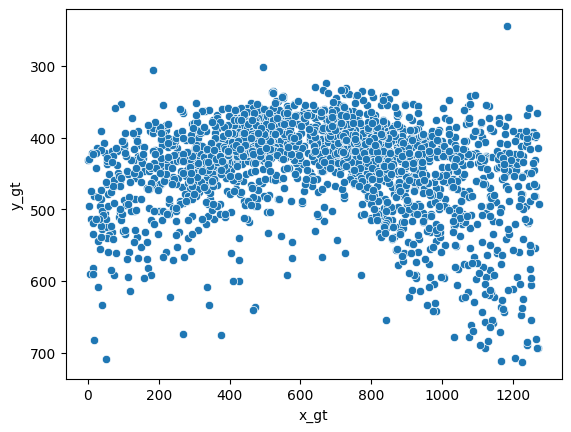

In [43]:
plt.gca().invert_yaxis()
sns.scatterplot(x='x_gt', y='y_gt', data=gt)


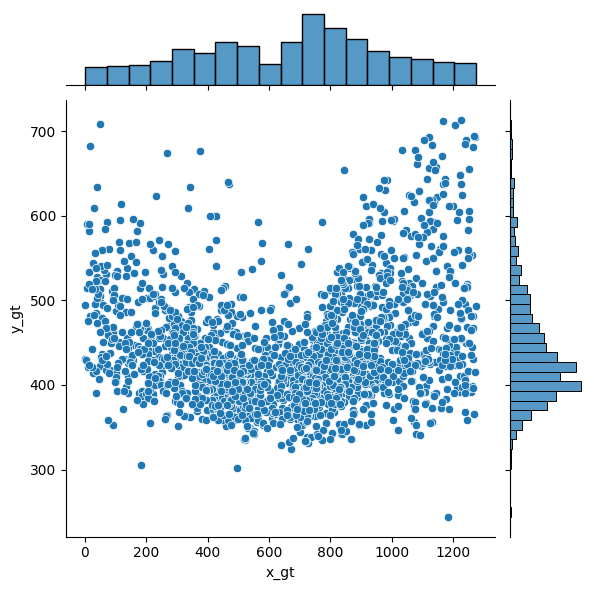

In [44]:
sns.jointplot(x='x_gt', y='y_gt', data=gt)

In [45]:
# we want to add a boolean column to df if (x_gt, y_gt) is in dfnl
# we want to add a boolean column to df if (x_gt, y_gt) is in dfl

# add a boolean column to gt if (x_gt, y_gt) is in dfnl
gt['in_dfnl'] = gt.apply(lambda row: True if (row['x_gt'], row['y_gt']) in zip(dfnl['x_gt'], dfnl['y_gt']) else False, axis=1)

In [46]:
# count number of True in in_dfnl
gt['in_dfnl'].value_counts()

in_dfnl
False    1828
True      225
Name: count, dtype: int64

In [4]:
# compute l1 distance between the ground truth and the predicted bounding box
dfnl['l1_distance'] = dfnl.apply(lambda row: abs(row['x_gt'] - row['x_pred']) + abs(row['y_gt'] - row['y_pred']), axis=1)
# compute distance on x-axis between the ground truth and the predicted bounding box
dfnl['x_distance'] = dfnl.apply(lambda row: abs(row['x_gt'] - row['x_pred']), axis=1)

# compute l1 distance between the ground truth and the predicted bounding box
dfl['l1_distance'] = dfl.apply(lambda row: abs(row['x_gt'] - row['x_pred']) + abs(row['y_gt'] - row['y_pred']), axis=1)
# compute distance on x-axis between the ground truth and the predicted bounding box
dfl['x_distance'] = dfl.apply(lambda row: abs(row['x_gt'] - row['x_pred']), axis=1)

Text(0, 0.5, 'density')

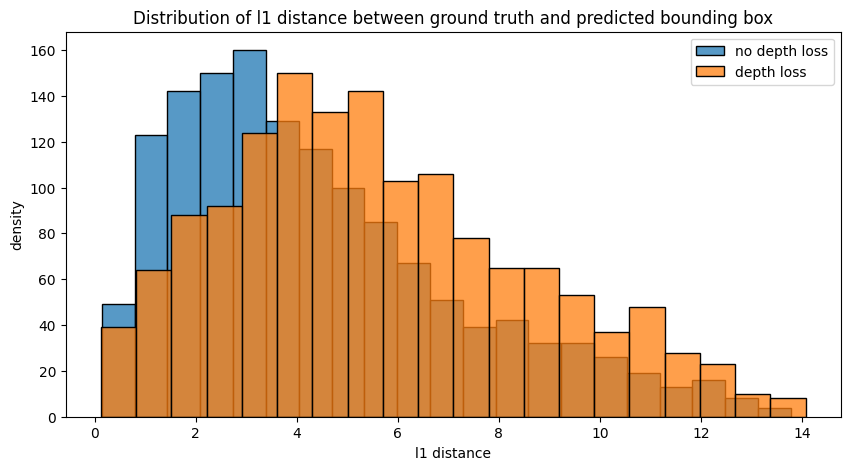

In [5]:
# plot the distribution of l1 distance using seaborn on the no depth loss model and the depth loss model
plt.figure(figsize=(10, 5))
sns.histplot(dfnl['l1_distance'], label='no depth loss')
sns.histplot(dfl['l1_distance'], label='depth loss')
plt.legend()
plt.title('Distribution of l1 distance between ground truth and predicted bounding box')
plt.xlabel('l1 distance')
plt.ylabel('density')

Text(0, 0.5, 'y_gt')

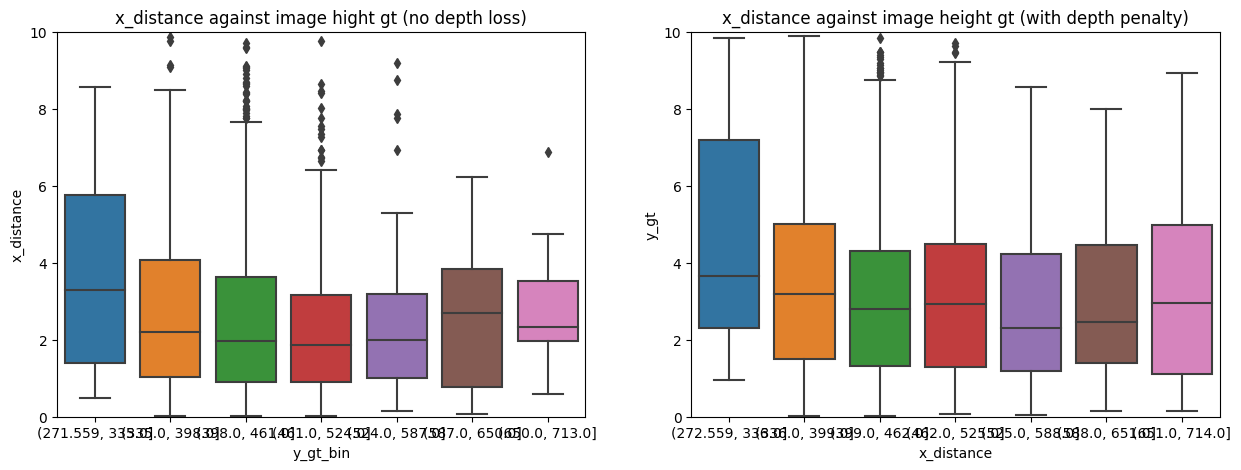

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


dfl['y_gt_bin'] = pd.cut(dfl['y_gt'], bins=7)
dfnl['y_gt_bin'] = pd.cut(dfnl['y_gt'], bins=7)

sns.boxplot(x='y_gt_bin', y='x_distance', data=dfnl, ax = ax1)
sns.boxplot(x='y_gt_bin', y='x_distance', data=dfl, ax = ax2)
ax1.set_title('x_distance against image hight gt (no depth loss)')
ax2.set_title('x_distance against image height gt (with depth penalty)')
ax1.set_ylim(0,10)
ax2.set_ylim(0,10)

ax2.set_xlabel('x_distance')
ax2.set_ylabel('y_gt')

In [7]:
dfnl['x_distance'].mean()

2.5587134152421673

In [8]:
dfl['x_distance'].mean()

3.1853064079670323

Text(0, 0.5, 'y_gt')

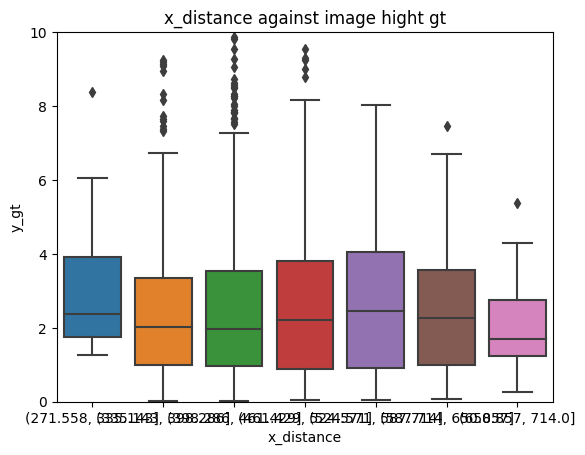

In [9]:
df = pd.read_csv('matching_detr_oap_r101_eos005_nod.csv')
df['l1_distance'] = df.apply(lambda row: abs(row['x_gt'] - row['x_pred']) + abs(row['y_gt'] - row['y_pred']), axis=1)
df['x_distance'] = df.apply(lambda row: abs(row['x_gt'] - row['x_pred']), axis=1)
df['y_gt_bin'] = pd.cut(df['y_gt'], bins=7)

sns.boxplot(x='y_gt_bin', y='x_distance', data=df)
plt.title('x_distance against image hight gt')
plt.ylim(0,10)
plt.xlabel('x_distance')
plt.ylabel('y_gt')

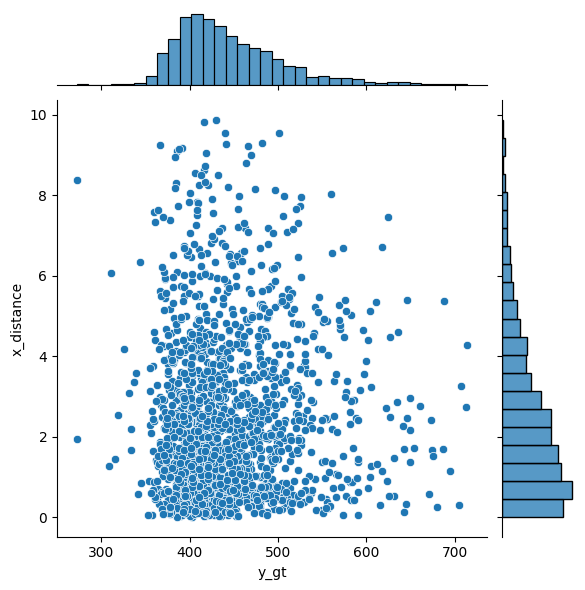

In [10]:
sns.jointplot(x='y_gt', y='x_distance', data=df)

Text(0, 0.5, 'y_gt')

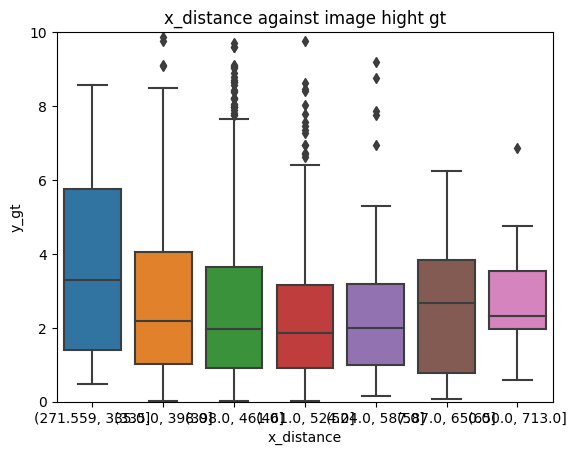

In [11]:
df2 = pd.read_csv('matching_detr_oap_r101_eos010_nod.csv')
df2['l1_distance'] = df2.apply(lambda row: abs(row['x_gt'] - row['x_pred']) + abs(row['y_gt'] - row['y_pred']), axis=1)
df2['x_distance'] = df2.apply(lambda row: abs(row['x_gt'] - row['x_pred']), axis=1)
df2['y_gt_bin'] = pd.cut(df2['y_gt'], bins=7)

sns.boxplot(x='y_gt_bin', y='x_distance', data=df2)
plt.title('x_distance against image hight gt')
plt.ylim(0,10)
plt.xlabel('x_distance')
plt.ylabel('y_gt')


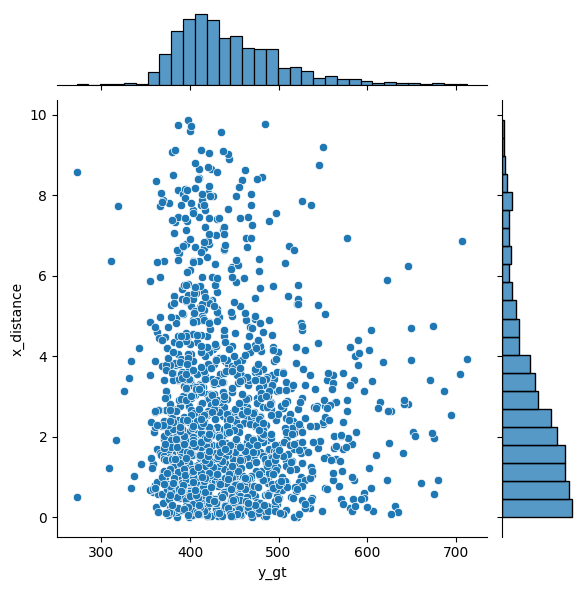

In [12]:
sns.jointplot(x='y_gt', y='x_distance', data=df2,)